In [266]:
import pandas as pd
import numpy as np
import re
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix
import seaborn as sns
import math
from sklearn.dummy import DummyClassifier
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import GaussianNB
import math
from collections import Counter, defaultdict

**Business Problem**

Data is collected from Memorial Sloan Cancer center. The task at hand is to classify the genetic mutations based on evidence from text based clinical literature.

**Objectives and constraints**


*   Errors are costly
*   Interpretability is important
*   No low latency requirement
*   Probability of a datapoitn belonging to a class is required.





In [267]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [268]:
#Let's read the data
df1=pd.read_csv("/content/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
df2=pd.read_csv("/content/training_variants")

In [269]:
# Size of the first dataset
df1.shape
# Head of the first dataset
df1.head(5)

(3321, 2)

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [270]:
# Size of the second dataset
df2.shape
# Head of the secong dataset
df2.head(5)

(3321, 4)

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


Let's join bot the datasets on ID

In [271]:
cancer_data=pd.merge(df1,df2,on="ID")

In [272]:
# Number of rows in the new dataframe are:
print("The number of datapoints are :",cancer_data.shape[0])
# Number of columns in the new dataframe are:
print("The number of features are :",cancer_data.shape[1])

The number of datapoints are : 3321
The number of features are : 5


Now, let's clean the data of stop words and punctuations.

In [273]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [274]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        cancer_data[column][index] = string

In [275]:
start_time = time.clock()
for index, row in cancer_data.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 32.68993899999987 seconds


In [276]:
cancer_data.loc[cancer_data["TEXT"].isnull(),"TEXT"]=cancer_data["Gene"]+" "+cancer_data["Variation"]

In [277]:
cancer_data[cancer_data['ID']==1109]

,ID,TEXT,Gene,Variation,Class
1109,1109,FANCA S1088F,FANCA,S1088F,1


In [278]:
cancer_data.Gene   = cancer_data.Gene.str.replace('\s+', '_')
cancer_data.Variation = cancer_data.Variation.str.replace('\s+', '_')

Now, let's explore whether the class is balanced or not.

In [279]:
cancer_data["Class"].value_counts()

7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: Class, dtype: int64

We can explore that most of the datapoints belong to class 7. Now, let's plot the distribution 

Text(0.5, 0, 'Class labels')

Text(0, 0.5, 'Values of corresponding labels')

The weightage of each class 8 is: 0.6 %
The weightage of each class 9 is: 1.1 %
The weightage of each class 3 is: 2.7 %
The weightage of each class 5 is: 7.3 %
The weightage of each class 6 is: 8.3 %
The weightage of each class 2 is: 13.6 %
The weightage of each class 1 is: 17.1 %
The weightage of each class 4 is: 20.7 %
The weightage of each class 7 is: 28.7 %


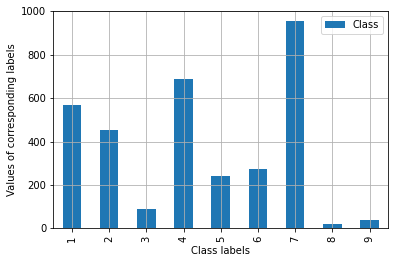

In [280]:
values=cancer_data["Class"].value_counts().sort_index()
values.plot(kind="bar")
plt.xlabel("Class labels")
plt.ylabel("Values of corresponding labels")
plt.legend()
plt.grid()
sorted_indexes=np.argsort(values)+1
values=cancer_data["Class"].value_counts()
for i in sorted_indexes:
  print("The weightage of each class",i,"is:",np.round((values[i]/np.sum(values))*100,1),"%")

Now, let's explore the features

Univariate Analysis of Gene

In [281]:
Gene_distribution=cancer_data["Gene"].value_counts()
Gene_distribution.head(5)

BRCA1    264
TP53     163
EGFR     141
PTEN     126
BRCA2    125
Name: Gene, dtype: int64

Text(0.5, 1.0, 'Gene Distribution')

Text(0.5, 0, 'Indexes')

Text(0, 0.5, 'Number of each type of gene')

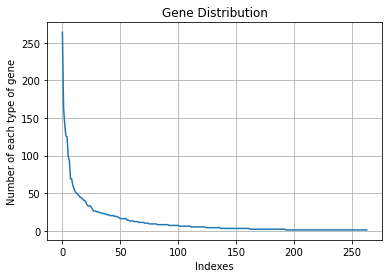

In [282]:
plt.plot(Gene_distribution.values)
plt.title("Gene Distribution")
plt.xlabel("Indexes")
plt.ylabel("Number of each type of gene")
plt.grid()

Clearly, the distribution resembles that of a power law.

Text(0.5, 1.0, 'CDF')

Text(0.5, 0, 'Indexes')

Text(0, 0.5, 'cumulative values')

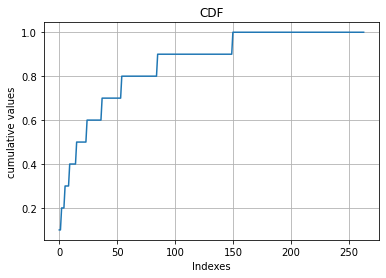

In [283]:
cum_sum=np.round(np.cumsum(Gene_distribution.values)/(np.sum(Gene_distribution.values)),1)
plt.plot(cum_sum)
plt.title("CDF")
plt.xlabel("Indexes")
plt.ylabel("cumulative values")
plt.grid()

50 genes are occuring more than 75% of times. 
We can't do analysis with pairplot as there are too many types of Genes. So, the only way to test feature significance is by using a classification model and using only "Gene" feature. If the log-loss is lesser than that of a random model's then we can conclude that the feature is significant.

So, next we have to build a random classification model. And calculate it's logloss. But, before that we have to split our data into test and CV.

In [284]:
Y=cancer_data["Class"]
X=cancer_data

In [285]:
X_train, X_CV, Y_train, Y_CV = train_test_split(X,Y, train_size=0.8)
X_CV,X_test, Y_CV,Y_test = train_test_split(X_CV,Y_CV, test_size=0.5)
print("The shapes of X_train, X_test and X_CV are:", X_train.shape, X_test.shape,X_CV.shape)
print("The shapes of X_train, X_test and X_CV are:", Y_train.shape, Y_test.shape,Y_CV.shape)

The shapes of X_train, X_test and X_CV are: (2656, 5) (333, 5) (332, 5)
The shapes of X_train, X_test and X_CV are: (2656,) (333,) (332,)


In order to test the model's we need confusion matrix too. So, let's create a function for that. Let's also create a precision and recall matrix for indepth understanding of how well the classification models are working.

In [286]:
def confusion_matrices(y_true,y_pred):
    C=confusion_matrix(y_true, y_pred)
    Precision_matrix=(C/C.sum(axis=0))
    Recall_matrix= (C.T/C.sum(axis=1)).T
    #let's plot this matrices

    # Confusion matrix plot
    labels=[1,2,3,4,5,6,7,8,9]
    plt.figure(figsize=(20,7))
    sns.heatmap(C,annot=True,cmap="YlGnBu",xticklabels=labels,yticklabels=labels)
    plt.xlabel("Predicted Class")
    plt.ylabel("True class")

    # precision plot
    plt.figure(figsize=(20,7))
    sns.heatmap(Precision_matrix,annot=True,cmap="YlGnBu",xticklabels=labels,yticklabels=labels)
    plt.xlabel("Predicted Class")
    plt.ylabel("True class")

    # Recall matrix
    plt.figure(figsize=(20,7))
    sns.heatmap(Recall_matrix,annot=True, cmap="YlGnBu",xticklabels=labels,yticklabels=labels)
    plt.xlabel("Predicted Class")
    plt.ylabel("True class")


Now, let's create the random model. Sklearn has a dummy classifier. So, we can directly use it. For dummy classifier, there is no hyperparameter tuning. So, we can directly use the dataset by breaking it into test and train.

In [287]:
#Let's split the dataset
X_train_dummy, X_test_dummy, Y_train_dummy, Y_test_dummy = train_test_split(X,Y, train_size=0.8)
#Fit the dummy model
dummy_clf=DummyClassifier(strategy="uniform")
dummy_clf.fit(X_train_dummy,Y_train_dummy)
#Get the predictions
Y_pred_dummy=dummy_clf.predict_proba(X_test_dummy)
#Now let's find out the logloss
print("The log_loss of the dummy classifier is:",log_loss(np.array(Y_test_dummy),Y_pred_dummy))

DummyClassifier(strategy='uniform')

The log_loss of the dummy classifier is: 2.1972245773362196


Now, let's plot the confusion matrix for dummy classifier

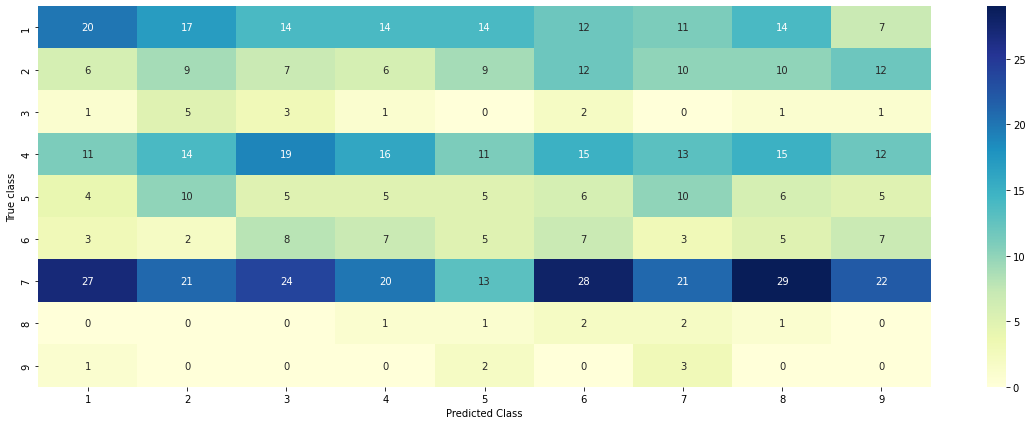

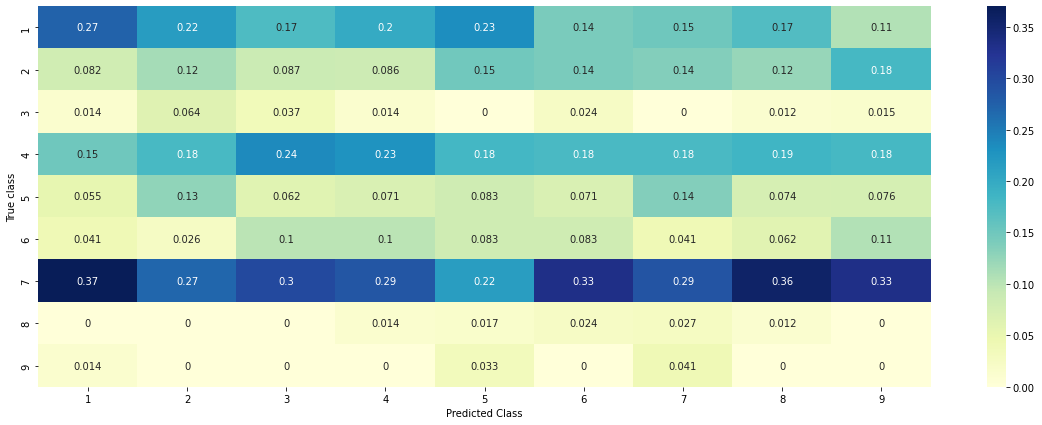

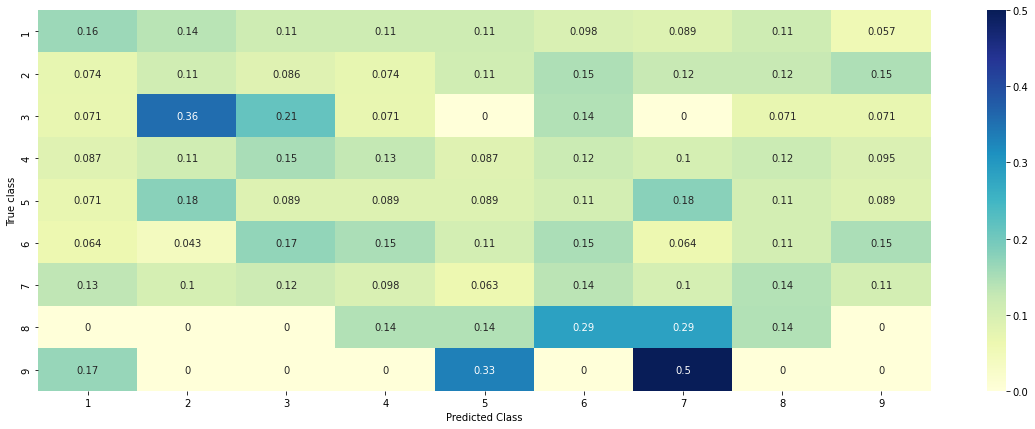

In [288]:
predicted_labels=dummy_clf.predict(X_test_dummy)
confusion_matrices(Y_test_dummy,predicted_labels)

The baseline log-loss is 2.2.

Now, we have to vectorise the Gene feature using response coding and TF-IDF vectoriser.

In [289]:
def get_gv_fea_dict(alpha, feature, df):
    value_count = X_train[feature].value_counts()
    gv_dict ={}
    for i, denominator in value_count.items():
        vec = []
        for k in range(1,10):
            cls_cnt = X_train.loc[(X_train['Class']==k) & (X_train[feature]==i)]
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))
        gv_dict[i]=vec
    return gv_dict


In [290]:
def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    value_count = X_train[feature].value_counts()
    gv_fea = []
    for index, row in df.iterrows():
        if row[feature] in gv_dict.keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return gv_fea

In [291]:
alpha=1
x_train_respnose_coding=get_gv_feature(alpha,"Gene",X_train)
x_cv_response_coding=get_gv_feature(alpha,"Gene",X_CV)
X_test_response_coding=get_gv_feature(alpha,"Gene",X_test)

Now, let's create TF-IDF vectoriser

In [292]:
vectorizer = TfidfVectorizer()
fit=vectorizer.fit(X_train["Gene"])
x_train_TFIDF_vectoriser=fit.transform(X_train["Gene"])
x_cv_TFIDF_vectoriser=vectorizer.transform(X_CV["Gene"])
x_test_TFIDF_vectoriser=vectorizer.transform(X_test["Gene"])

Now, let us run logistic regression with only Gene feature.

In [328]:
#First, let's use response coding and then TFIDF vectoriser

def Classification_with_optimised_hyperparamter(type_of_loss,X_train,X_CV,X_test,Y_train,Y_CV):
    alpha=[10 ** x for x in range(-5, 1)] 
    cv_log_errors=[]
    for i in alpha:
        clf = SGDClassifier(alpha=i, penalty='l2', loss=type_of_loss, random_state=42)
        clf.fit(X_train, Y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(X_train, Y_train)
        predict_y = sig_clf.predict_proba(X_CV)
        cv_log_errors.append(log_loss(Y_CV, predict_y, labels=clf.classes_, eps=1e-15))

    plt.plot(alpha, cv_log_errors,c='g')
    plt.grid()
    plt.title("Cross Validation Error for each alpha")
    plt.xlabel("Alpha i's")
    plt.ylabel("Error measure")
    plt.show()


    best_alpha = np.argmin(cv_log_errors)
    clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, Y_train)

    predict_y = sig_clf.predict_proba(X_train)
    print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
    predict_y = sig_clf.predict_proba(X_CV)
    print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_CV, predict_y, labels=clf.classes_, eps=1e-15))
    predict_y = sig_clf.predict_proba(X_test)
    print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
    return sig_clf.predict(X_test)

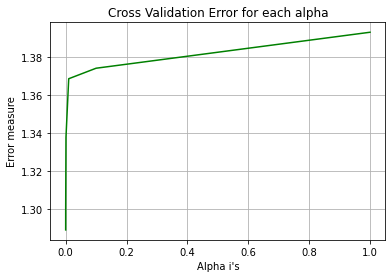

For values of best alpha =  1e-05 The train log loss is: 1.1623387380399721
For values of best alpha =  1e-05 The cross validation log loss is: 1.289013833882641
For values of best alpha =  1e-05 The test log loss is: 1.310658888440282


array([1, 4, 1, 7, 7, 1, 6, 1, 2, 2, 4, 1, 7, 7, 4, 4, 2, 1, 1, 7, 7, 9,
       2, 1, 7, 6, 4, 7, 4, 1, 7, 2, 4, 7, 4, 5, 7, 9, 4, 4, 1, 7, 7, 2,
       2, 7, 7, 7, 1, 6, 4, 1, 7, 7, 7, 4, 1, 7, 2, 5, 7, 7, 1, 7, 7, 1,
       1, 1, 2, 7, 5, 1, 6, 7, 1, 6, 7, 7, 1, 4, 4, 2, 7, 4, 1, 2, 5, 4,
       7, 7, 1, 4, 1, 4, 1, 1, 6, 4, 5, 4, 5, 1, 1, 2, 1, 7, 7, 1, 1, 7,
       7, 4, 7, 7, 7, 2, 7, 4, 2, 6, 4, 7, 7, 1, 5, 2, 2, 2, 4, 1, 4, 1,
       7, 7, 1, 2, 4, 7, 2, 5, 7, 7, 7, 7, 7, 7, 1, 6, 1, 2, 7, 6, 1, 7,
       7, 6, 7, 4, 1, 7, 7, 7, 7, 7, 2, 7, 6, 5, 1, 2, 7, 2, 4, 7, 5, 7,
       2, 7, 1, 7, 2, 7, 2, 1, 6, 4, 7, 2, 7, 7, 7, 4, 4, 1, 1, 7, 1, 1,
       7, 7, 7, 1, 1, 4, 2, 4, 7, 7, 4, 7, 7, 4, 4, 4, 7, 7, 7, 7, 1, 5,
       6, 1, 1, 7, 4, 1, 7, 7, 5, 7, 1, 1, 6, 4, 6, 7, 7, 4, 1, 7, 4, 1,
       7, 5, 5, 1, 4, 1, 7, 7, 2, 4, 4, 6, 4, 1, 7, 1, 7, 7, 7, 1, 4, 6,
       1, 7, 7, 1, 2, 4, 9, 1, 7, 1, 7, 1, 4, 1, 7, 4, 7, 7, 2, 1, 7, 4,
       6, 7, 1, 7, 1, 1, 2, 7, 2, 5, 1, 7, 1, 4, 7,

In [329]:
#Logistic regression with Gene feature encoded with response coding
Classification_with_optimised_hyperparamter("log",x_train_respnose_coding,x_cv_response_coding,X_test_response_coding,Y_train,Y_CV)

So, using the response encoded Gene feature and Logistic regression, we found out that, Gene feature is significant as the test log-loss is 1.21, which is less than that of dummy model. Now,let's try with TF-IDF vectorised values. 

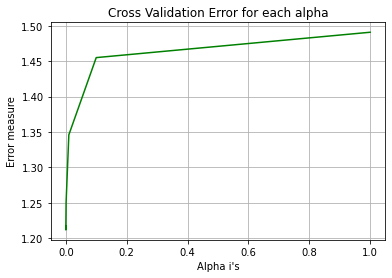

For values of best alpha =  0.0001 The train log loss is: 0.9816533321573426
For values of best alpha =  0.0001 The cross validation log loss is: 1.2116781111152395
For values of best alpha =  0.0001 The test log loss is: 1.195228961828497


array([1, 4, 1, 7, 7, 1, 6, 1, 7, 7, 4, 1, 7, 7, 4, 4, 7, 1, 1, 7, 7, 9,
       7, 4, 7, 6, 4, 7, 4, 1, 7, 7, 4, 7, 4, 5, 7, 9, 4, 4, 9, 7, 7, 2,
       2, 7, 7, 7, 4, 6, 4, 1, 7, 7, 7, 4, 4, 7, 7, 5, 7, 7, 1, 7, 7, 1,
       1, 1, 7, 7, 5, 1, 6, 7, 1, 6, 7, 7, 1, 4, 4, 7, 7, 4, 1, 7, 5, 4,
       7, 7, 1, 4, 1, 4, 1, 1, 6, 4, 5, 4, 5, 5, 1, 7, 4, 7, 7, 1, 1, 7,
       7, 4, 7, 7, 7, 2, 7, 4, 7, 6, 4, 7, 7, 1, 5, 7, 7, 7, 4, 1, 4, 1,
       7, 7, 1, 2, 4, 7, 7, 5, 7, 7, 7, 7, 7, 7, 2, 6, 1, 2, 7, 6, 1, 7,
       7, 6, 7, 4, 1, 7, 7, 7, 7, 7, 7, 7, 6, 5, 1, 2, 7, 7, 4, 7, 5, 7,
       7, 7, 1, 7, 2, 7, 7, 1, 6, 4, 7, 2, 7, 7, 7, 4, 4, 4, 1, 7, 1, 1,
       7, 7, 7, 1, 1, 4, 2, 4, 7, 7, 4, 7, 7, 4, 4, 4, 7, 7, 7, 7, 1, 5,
       6, 1, 1, 7, 4, 1, 2, 7, 5, 7, 1, 1, 6, 4, 6, 7, 7, 4, 1, 7, 4, 1,
       7, 5, 5, 9, 4, 1, 7, 7, 2, 4, 4, 6, 4, 4, 7, 1, 7, 7, 7, 1, 4, 6,
       1, 7, 7, 4, 7, 4, 9, 1, 7, 1, 7, 1, 4, 1, 7, 4, 7, 7, 7, 4, 7, 4,
       6, 7, 1, 7, 1, 1, 7, 7, 2, 5, 1, 7, 1, 4, 7,

In [330]:
Classification_with_optimised_hyperparamter("log",x_train_TFIDF_vectoriser,x_cv_TFIDF_vectoriser,x_test_TFIDF_vectoriser,Y_train,Y_CV)

It is evident from the log-loss above that the TFIDF vectorisation is working better. We also have to  find out whether the feature is stable across the datasets. 

In [331]:
def stability(feature):
    test_coverage=X_test[X_test[feature].isin(list(set(X_train[feature])))].shape[0]
    cv_coverage=X_CV[X_CV[feature].isin(list(set(X_train[feature])))].shape[0]
    print('Ans\n1. In test data',test_coverage, 'out of',X_test.shape[0], ":",(test_coverage/X_test.shape[0])*100)
    print('2. In cross validation data',cv_coverage, 'out of ',X_CV.shape[0],":" ,(cv_coverage/X_CV.shape[0])*100)


In [332]:
stability("Gene")

Ans
1. In test data 320 out of 333 : 96.09609609609609
2. In cross validation data 327 out of  332 : 98.49397590361446


In [333]:
#Univariate analysis of variation feature
Variation_distribution=cancer_data["Variation"].value_counts()
Variation_distribution.head(5)

Truncating_Mutations    93
Deletion                74
Amplification           71
Fusions                 34
Overexpression           6
Name: Variation, dtype: int64

Text(0.5, 1.0, 'Variation Distribution')

Text(0.5, 0, 'Indexes')

Text(0, 0.5, 'Number of each type of gene')

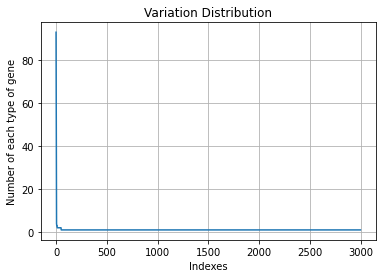

In [334]:
plt.plot(Variation_distribution.values)
plt.title("Variation Distribution")
plt.xlabel("Indexes")
plt.ylabel("Number of each type of gene")
plt.grid()

Only top four values occur tens of times, rest of the variations don't occur frequently.

Text(0.5, 1.0, 'CDF')

Text(0.5, 0, 'Indexes')

Text(0, 0.5, 'cumulative values')

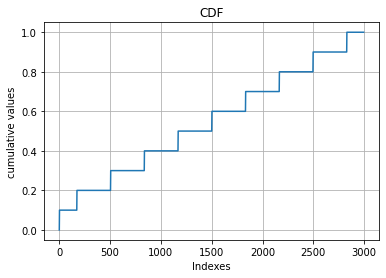

In [335]:
cum_sum=np.round(np.cumsum(Variation_distribution.values)/(np.sum(Variation_distribution.values)),1)
plt.plot(cum_sum)
plt.title("CDF")
plt.xlabel("Indexes")
plt.ylabel("cumulative values")
plt.grid()

So, the occurence of variation types is more or less unifrom. Only top four mostly occuring features are outliers. Now, let us vectorise using response coding.

In [336]:
alpha=1
x_train_variation_respnose_coding=get_gv_feature(alpha,"Variation",X_train)
x_cv_variation_response_coding=get_gv_feature(alpha,"Variation",X_CV)
X_test_variation_response_coding=get_gv_feature(alpha,"Variation",X_test)

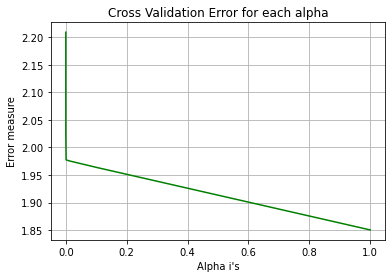

For values of best alpha =  1 The train log loss is: 1.0224161425856435
For values of best alpha =  1 The cross validation log loss is: 1.850446018917222
For values of best alpha =  1 The test log loss is: 1.7478671624761604


array([7, 7, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 1, 1, 7, 7, 7,
       7, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 1, 7, 7, 7, 1, 1, 7, 7, 7, 7, 7, 7, 7, 2, 7,
       7, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 1, 7, 7, 7, 7, 7, 7, 1, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 1, 7, 1, 1, 7, 7, 7, 7, 7, 7, 1, 7,
       7, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 1, 7, 7, 7, 1, 1,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 1, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 2, 1, 7, 7, 7, 7, 1, 7, 7, 7, 7, 7, 1, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 1, 7, 7, 1, 1, 7, 7, 7, 7, 2, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7,
       7, 7, 7, 7, 7, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7,

In [337]:
#Logistic regression with variation feature encoded with response coding
Classification_with_optimised_hyperparamter("log",x_train_variation_respnose_coding,x_cv_variation_response_coding,X_test_variation_response_coding,Y_train,Y_CV)

In [338]:
fit=vectorizer.fit(X_train["Variation"])
x_train_variation_TFIDF_coding=fit.transform(X_train["Variation"])
x_cv_variation_TFIDF_coding=vectorizer.transform(X_CV["Variation"])
X_test_variation_TFIDF_coding=vectorizer.transform(X_test["Variation"])

There is a significant difference between train loss and test-loss,which means that the model is clearly overfitted. Nevetheles, the model has performed better than dummy one.

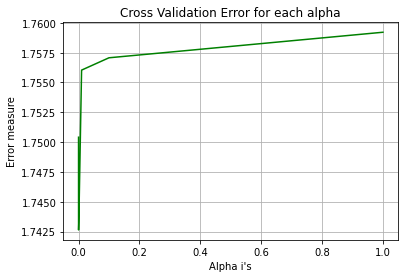

For values of best alpha =  0.0001 The train log loss is: 0.6701514464434786
For values of best alpha =  0.0001 The cross validation log loss is: 1.7426378156042557
For values of best alpha =  0.0001 The test log loss is: 1.6514864946422654


array([7, 7, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 1, 1, 7, 7, 7,
       7, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 2,
       2, 7, 7, 7, 7, 7, 7, 1, 7, 7, 7, 1, 1, 7, 7, 7, 7, 7, 7, 7, 2, 7,
       7, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 1, 7, 7, 7, 7, 7, 7, 1, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 1, 7, 1, 1, 7, 7, 7, 7, 7, 7, 1, 7,
       7, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 2, 7, 7, 7, 7, 7, 7,
       7, 7, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 1, 7, 7, 7, 1, 1,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 1, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 2, 1, 7, 7, 7, 7, 1, 7, 7, 7, 7, 7, 1, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 1, 7, 7, 1, 1, 7, 7, 7, 7, 2, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7,
       7, 7, 7, 7, 7, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7,

In [339]:
#Logistic regression with variation feature encoded with TF-IDF
Classification_with_optimised_hyperparamter("log",x_train_variation_TFIDF_coding,x_cv_variation_TFIDF_coding,X_test_variation_TFIDF_coding,Y_train,Y_CV)

Again, the model is facing overfitting issues. With, TF-IDF, the model has overfit much more. Nevertheless, it is better than the dummy model and we can conclude that Variation feature is significant. Now, let's test the significance of text feature.

In [340]:
# def get_dictionary(X_train):
#   single_Class={}
#   for sentence in X_train["TEXT"]:
#       value_count=pd.Series(sentence.split()).value_counts()
#       for word,denominator in value_count.items():
#         if word in single_Class.keys():
#           single_Class[word]+=denominator
#         else:
#           single_Class[word]=denominator
#   return single_Class

In [341]:
# total_dict=get_dictionary(X_train)
# diction={}
# for i in range(1,10):
#   diction[i]=get_dictionary(X_train[X_train["Class"]==i])

In [342]:
# /*def get_text_responsecoding(df):   
#     text_feature_responseCoding = np.zeros((df.shape[0],9))
#     for i in range(1,10):
#       row_index = 0
#       for index,row in X_train.iterrows():
#         sum_prob=0
#         for word in row["TEXT"].split():
#               sum_prob += math.log(((diction[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
#               text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
#         text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
#         row_index += 1    
#     return text_feature_responseCoding 
    

In [343]:
#train_text_feature_responseCoding  = get_text_responsecoding(X_train)
#test_text_feature_responseCoding  = get_text_responsecoding(X_CV)
#cv_text_feature_responseCoding  = get_text_responsecoding(X_test)

In [344]:
#Univariate analysis on text feature
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [345]:
import math
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [346]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = X_train[X_train['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(X_train)

In [347]:
train_text_feature_responseCoding  = np.array(get_text_responsecoding(X_train))
test_text_feature_responseCoding  = np.array(get_text_responsecoding(X_CV))
cv_text_feature_responseCoding  = np.array(get_text_responsecoding(X_test))

In [348]:
fit=vectorizer.fit(X_train["TEXT"])
x_train_text_TFIDF_coding=fit.transform(X_train["TEXT"])
x_cv_text_TFIDF_coding=vectorizer.transform(X_CV["TEXT"])
X_test_text_TFIDF_coding=vectorizer.transform(X_test["TEXT"])

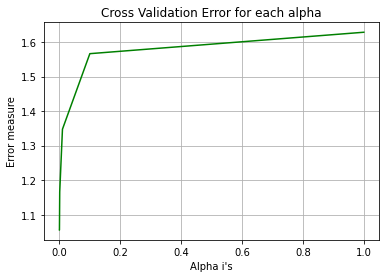

For values of best alpha =  1e-05 The train log loss is: 0.5718199933773914
For values of best alpha =  1e-05 The cross validation log loss is: 1.055839722941602
For values of best alpha =  1e-05 The test log loss is: 1.006360170171244


array([1, 4, 1, 7, 7, 4, 6, 1, 7, 7, 4, 4, 7, 7, 4, 4, 7, 4, 1, 4, 7, 9,
       2, 1, 7, 5, 7, 7, 4, 4, 7, 7, 1, 7, 4, 1, 7, 9, 4, 4, 9, 7, 7, 2,
       2, 2, 7, 7, 3, 6, 4, 1, 2, 6, 7, 4, 4, 2, 7, 3, 7, 5, 1, 7, 7, 1,
       4, 1, 7, 7, 4, 1, 6, 7, 1, 5, 2, 2, 1, 5, 4, 7, 7, 4, 1, 2, 1, 4,
       2, 7, 6, 4, 4, 4, 7, 1, 6, 4, 1, 4, 1, 1, 1, 2, 1, 7, 7, 1, 1, 7,
       6, 4, 1, 7, 5, 2, 7, 4, 7, 6, 4, 6, 7, 1, 1, 2, 7, 7, 4, 1, 1, 4,
       7, 7, 1, 2, 1, 7, 7, 4, 7, 7, 7, 7, 7, 2, 7, 6, 1, 7, 7, 1, 4, 7,
       7, 6, 7, 4, 1, 2, 2, 7, 7, 7, 7, 7, 5, 4, 4, 2, 7, 7, 4, 6, 6, 7,
       7, 7, 4, 2, 7, 7, 2, 4, 5, 4, 7, 2, 7, 7, 7, 4, 4, 4, 1, 4, 1, 5,
       7, 7, 7, 4, 4, 4, 2, 4, 2, 7, 1, 7, 7, 4, 4, 4, 7, 7, 7, 7, 1, 1,
       5, 1, 4, 7, 1, 7, 7, 7, 5, 2, 1, 1, 6, 4, 6, 7, 5, 1, 1, 7, 1, 7,
       7, 6, 6, 9, 4, 1, 7, 7, 2, 1, 4, 5, 4, 2, 2, 4, 2, 7, 7, 1, 4, 6,
       4, 7, 7, 2, 7, 4, 9, 2, 2, 1, 2, 4, 4, 1, 4, 7, 7, 2, 7, 1, 2, 1,
       6, 7, 1, 7, 1, 1, 2, 7, 2, 1, 4, 2, 1, 4, 7,

In [349]:
#Logistic regression with Text feature encoded with TF-IDF
Classification_with_optimised_hyperparamter("log",x_train_text_TFIDF_coding,x_cv_text_TFIDF_coding,X_test_text_TFIDF_coding,Y_train,Y_CV)

Again, there is overfit with TFIDF. But, the TEXT feature is significant.

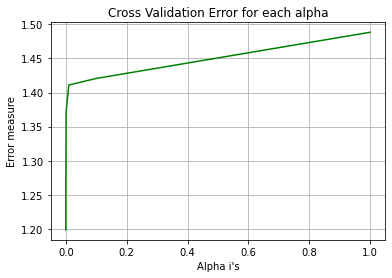

For values of best alpha =  1e-05 The train log loss is: 0.8772120429906619
For values of best alpha =  1e-05 The cross validation log loss is: 1.198659016797398
For values of best alpha =  1e-05 The test log loss is: 1.1498357725681962


array([1, 4, 1, 7, 7, 1, 6, 1, 2, 7, 4, 4, 7, 7, 4, 4, 7, 4, 1, 4, 7, 9,
       2, 1, 7, 6, 7, 7, 4, 4, 7, 7, 1, 7, 4, 1, 2, 9, 4, 7, 1, 7, 7, 2,
       2, 2, 7, 7, 1, 6, 4, 7, 2, 6, 7, 4, 1, 2, 7, 4, 7, 7, 1, 7, 7, 1,
       4, 7, 7, 7, 4, 1, 6, 1, 2, 6, 2, 7, 1, 1, 4, 7, 7, 4, 1, 2, 1, 4,
       2, 7, 1, 4, 1, 4, 7, 1, 6, 4, 1, 4, 4, 1, 1, 2, 1, 7, 2, 1, 1, 7,
       7, 4, 7, 7, 7, 2, 7, 4, 2, 6, 4, 7, 7, 7, 5, 2, 7, 7, 4, 1, 1, 4,
       7, 7, 1, 2, 4, 7, 7, 4, 7, 4, 7, 7, 7, 7, 2, 6, 1, 2, 7, 1, 4, 7,
       7, 6, 7, 4, 1, 2, 2, 7, 7, 7, 7, 7, 5, 4, 1, 2, 7, 7, 4, 7, 4, 7,
       7, 7, 4, 7, 7, 7, 2, 4, 5, 4, 7, 2, 7, 7, 7, 4, 4, 4, 1, 7, 4, 4,
       7, 7, 7, 4, 5, 4, 2, 4, 2, 2, 4, 7, 7, 4, 4, 4, 7, 7, 7, 7, 1, 1,
       6, 1, 1, 7, 1, 7, 2, 7, 5, 7, 1, 1, 6, 4, 6, 7, 2, 1, 1, 7, 4, 7,
       7, 6, 6, 9, 4, 1, 7, 7, 2, 1, 4, 6, 4, 2, 2, 1, 2, 7, 2, 1, 4, 6,
       1, 7, 7, 2, 7, 4, 9, 2, 2, 1, 2, 4, 4, 1, 4, 7, 2, 2, 7, 1, 2, 4,
       6, 7, 1, 7, 4, 1, 2, 7, 2, 1, 4, 7, 4, 4, 7,

In [350]:
#Logistic regression with Text feature encoded with responsecoding
Classification_with_optimised_hyperparamter("log",train_text_feature_responseCoding,test_text_feature_responseCoding,cv_text_feature_responseCoding,Y_train,Y_CV)

Again, we can clearly observe overfitting with responsecoding.

In [351]:
#stacking all the features together
x_train_respnose_coding1=np.hstack((x_train_respnose_coding,x_train_variation_respnose_coding))
x_cv_response_coding1=np.hstack((x_cv_response_coding,x_cv_variation_response_coding))
X_test_response_coding1=np.hstack((X_test_response_coding,X_test_variation_response_coding))

X_train_response=np.hstack((x_train_respnose_coding1,train_text_feature_responseCoding))
X_cv_response=np.hstack((x_cv_response_coding1,test_text_feature_responseCoding))
x_test_response=np.hstack((X_test_response_coding1,cv_text_feature_responseCoding))

In [352]:
X_train_response=X_train_response.tolist()
X_cv_response=X_cv_response.tolist()
x_test_response=x_test_response.tolist()

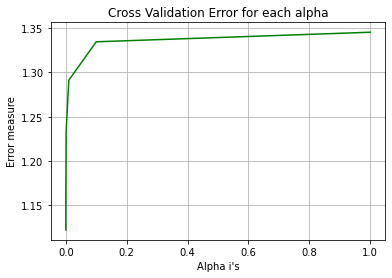

For values of best alpha =  1e-05 The train log loss is: 0.6194534512625156
For values of best alpha =  1e-05 The cross validation log loss is: 1.122278251152736
For values of best alpha =  1e-05 The test log loss is: 1.074375949571666


In [353]:
#Logistic regression with responsecoding
T_predict=Classification_with_optimised_hyperparamter("log",X_train_response,X_cv_response,x_test_response,Y_train,Y_CV)

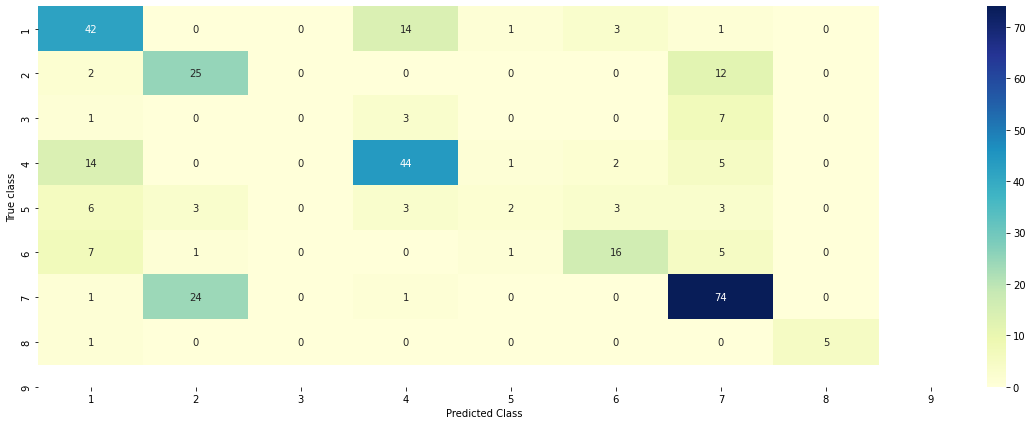

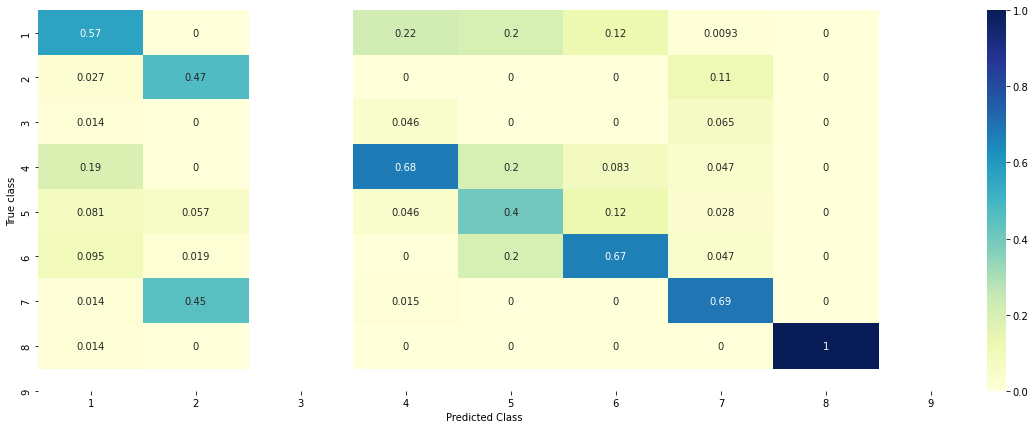

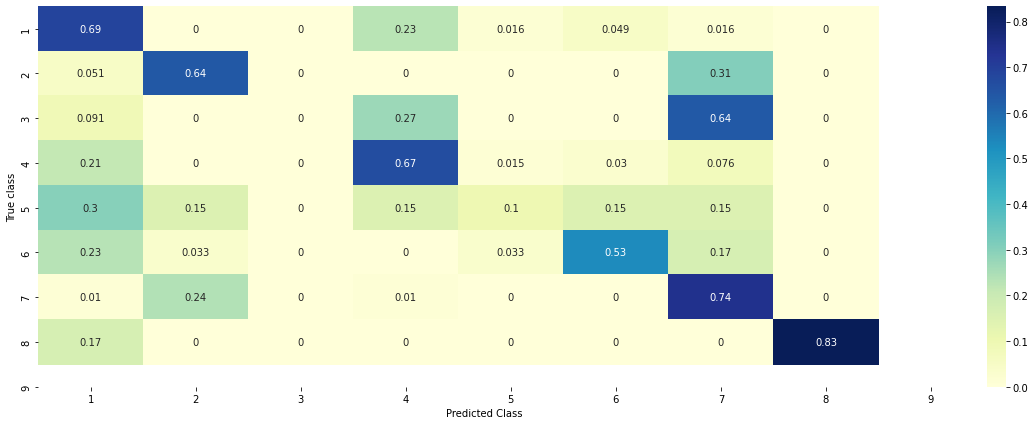

In [354]:
confusion_matrices(Y_test,T_predict)

In [355]:
#stacking all TFIDF features together
from scipy.sparse import hstack
x_train_TFIDF_coding1=hstack((x_train_TFIDF_vectoriser,x_train_variation_TFIDF_coding))
x_cv_TFIDF_coding1=hstack((x_cv_TFIDF_vectoriser,x_cv_variation_TFIDF_coding))
X_test_TFIDF_coding1=hstack((x_test_TFIDF_vectoriser,X_test_variation_TFIDF_coding))

X_train_TFIDF=hstack((x_train_TFIDF_coding1,x_train_text_TFIDF_coding)).tocsr()
X_cv_TFIDF=hstack((x_cv_TFIDF_coding1,x_cv_text_TFIDF_coding)).tocsr()
x_test_TFIDF=hstack((X_test_TFIDF_coding1,X_test_text_TFIDF_coding)).tocsr()

train_y = np.array(list(X_train['Class']))
cv_y = np.array(list(X_CV['Class']))
test_y = np.array(list(X_test['Class']))


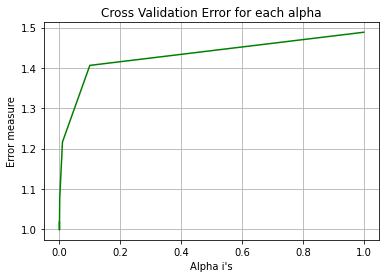

For values of best alpha =  0.0001 The train log loss is: 0.35692304242933753
For values of best alpha =  0.0001 The cross validation log loss is: 0.9980597624209303
For values of best alpha =  0.0001 The test log loss is: 0.9011561757103337


In [356]:
#Logistic regression with responsecoding
predicted_T1=Classification_with_optimised_hyperparamter("log",X_train_TFIDF,X_cv_TFIDF,x_test_TFIDF,train_y,cv_y)

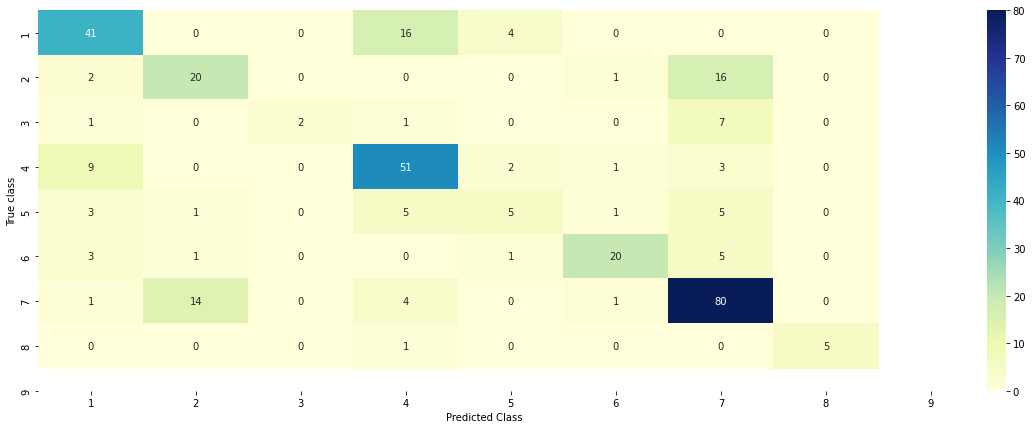

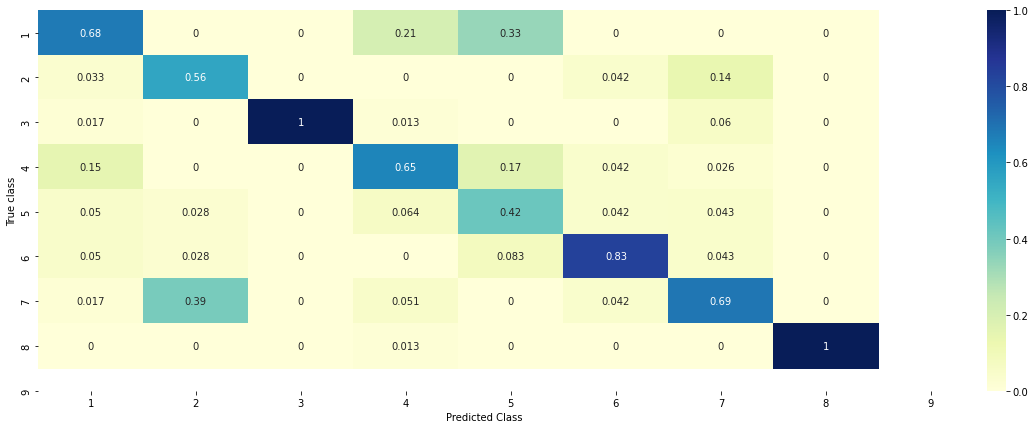

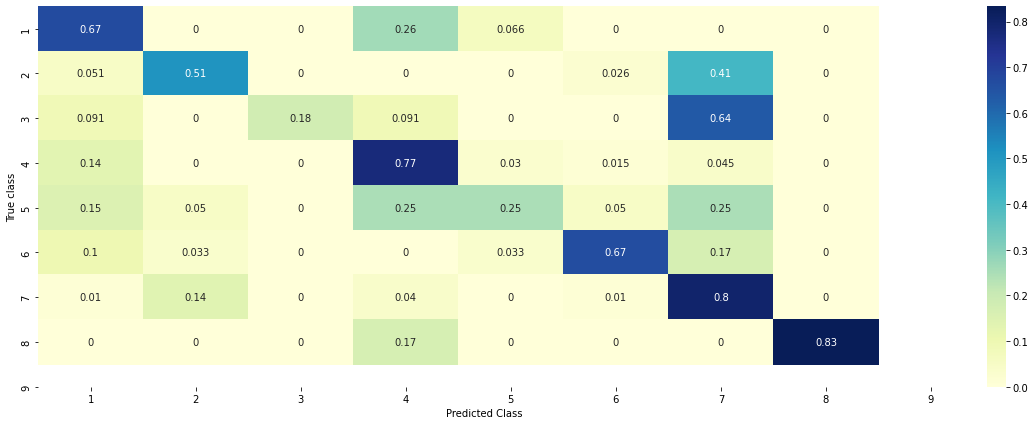

In [357]:
confusion_matrices(Y_test,predicted_T1)

Clearly there is an overfit with TFIDF features